Problem Statement

We aim to analyze Dubai real estate market to:

Identify high-price areas

Understand price drivers

Build a price prediction model

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,r2_score

In [5]:
df = pd.read_csv("bayut_selling_properties.csv")
print (df.shape
df.head()

(41381, 22)


,price,price_category,type,beds,baths,address,furnishing,completion_status,post_date,average_rent,building_name,year_of_completion,total_parking_spaces,total_floors,total_building_area_sqft,elevators,area_name,city,country,Latitude,Longitude,purpose
0,1450000,Medium,Apartment,1,2,"The Bay, Business Bay, Dubai",Furnished,Ready,2024-04-15,0,Unknown,0,0,0,0,0,Business Bay,Dubai,UAE,25.189427,55.264819,For Sale
1,6600000,High,Townhouse,5,5,"Brookfield, DAMAC Hills, Dubai",Unfurnished,Ready,2024-04-15,0,Unknown,0,0,0,0,0,DAMAC Hills,Dubai,UAE,25.028148,55.264246,For Sale
2,4825000,High,Apartment,2,3,"Vida Residence Downtown, Downtown Dubai, Dubai",Unfurnished,Ready,2024-04-18,288929,VIDA RESIDENCE DOWNTOWN,2018,510,56,1,11,Downtown Dubai,Dubai,UAE,25.186684,55.274705,For Sale
3,980000,Average,Apartment,3,3,"Building 39, Al Reef Downtown, Al Reef, Abu Dhabi",Unfurnished,Ready,2024-01-03,73384,Unknown,0,0,0,0,0,Al Reef,Abu Dhabi,UAE,24.466437,54.656891,For Sale
4,2499999,Medium,Townhouse,3,4,"Nima, The Valley, Dubai",Furnished,Off-Plan,2024-02-28,0,Unknown,0,0,0,0,0,The Valley,Dubai,UAE,25.019221,55.447201,For Sale


In [7]:
df.drop_duplicates(inplace=True)
print(df.isnull().sum())

price                        0
price_category               0
type                         0
beds                         0
baths                        0
address                      0
furnishing                   0
completion_status            0
post_date                    0
average_rent                 0
building_name                0
year_of_completion           0
total_parking_spaces         0
total_floors                 0
total_building_area_sqft     0
elevators                    0
area_name                    0
city                         0
country                      0
Latitude                    18
Longitude                   18
purpose                      0
dtype: int64


In [8]:
df = df.drop(columns=["Latitude","Longitude","country"])

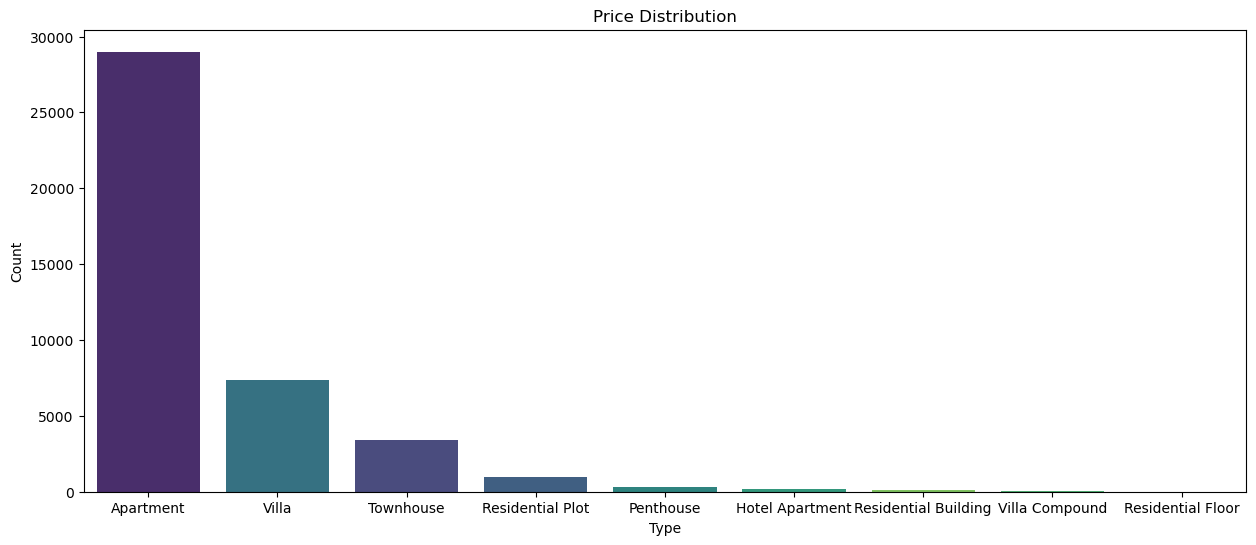

In [54]:
plt.figure(figsize=(15,6))
sns.countplot(data=df,  x='type', order=df['type'].value_counts().index,  palette='viridis',hue='type',      legend=False)
plt.title('Price Distribution')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

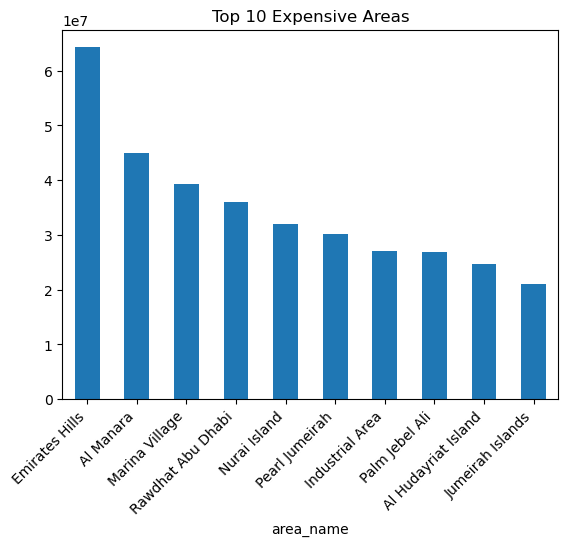

In [68]:
top_price = df.groupby("area_name")["price"].mean().sort_values(ascending=False).head(10)
top_price.plot(kind="bar")
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Expensive Areas")
plt.show()

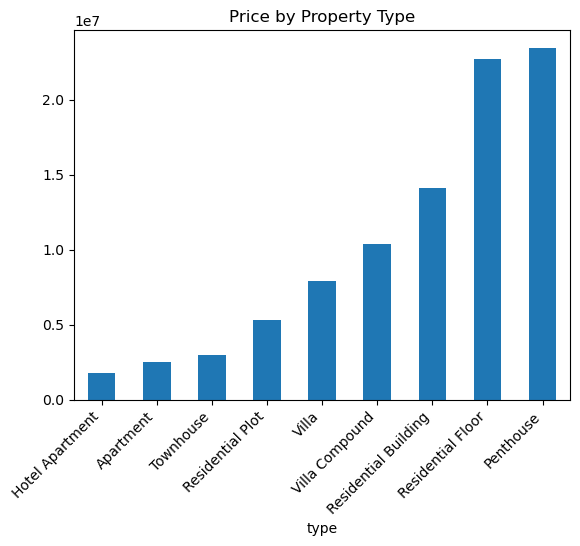

In [81]:
df.groupby("type")["price"].mean().sort_values().plot(kind="bar")
plt.title("Price by Property Type")
plt.xticks(rotation=45, ha='right')
plt.show()

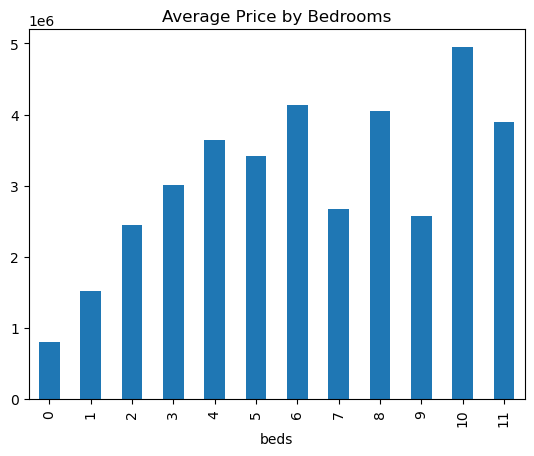

In [96]:
df.groupby("beds")["price"].mean().plot(kind="bar")
plt.title("Average Price by Bedrooms")
plt.show()

In [97]:
df_model = df.copy()

df_model = pd.get_dummies(df_model, columns=["type","completion_status"], drop_first=True)

In [99]:

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error

df = df.drop_duplicates()
df = df.dropna(subset=['price'])
df = df[df['price'] > 10000]

Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

df = df[(df['price'] >= Q1 - 1.5 * IQR) &
        (df['price'] <= Q3 + 1.5 * IQR)]

df['price_log'] = np.log(df['price'])

features = ['beds', 'baths', 'city', 'area_name',
            'type', 'furnishing', 'completion_status']

X = df[features]
y = df['price_log']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

categorical_cols = ['city', 'area_name', 'type',
                    'furnishing', 'completion_status']

numeric_cols = ['beds', 'baths']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=300,
        max_depth=20,
        random_state=42
    ))
])

rf_pipeline.fit(X_train, y_train)

y_pred_log = rf_pipeline.predict(X_test)

y_pred = np.exp(y_pred_log)
y_test_actual = np.exp(y_test)

print("📌 Random Forest Results")
print("R2 Score:", r2_score(y_test_actual, y_pred))
print("MAE:", mean_absolute_error(y_test_actual, y_pred))

gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        random_state=42
    ))
])

gb_pipeline.fit(X_train, y_train)

y_pred_log = gb_pipeline.predict(X_test)

y_pred = np.exp(y_pred_log)

print("\n📌 Gradient Boosting Results")
print("R2 Score:", r2_score(y_test_actual, y_pred))
print("MAE:", mean_absolute_error(y_test_actual, y_pred))

cv_scores = cross_val_score(
    rf_pipeline,
    X,
    y,
    cv=5,
    scoring='r2'
)

print("\n📌 Cross Validation R2:", cv_scores.mean())

📌 Random Forest Results
R2 Score: 0.786311198540639
MAE: 439777.3988214132

📌 Gradient Boosting Results
R2 Score: 0.7630012288694414
MAE: 469747.87458625325

📌 Cross Validation R2: 0.8448102377045072


In [100]:
df['price'].mean()

np.float64(2220015.490969721)

In [101]:
439777 / df['price'].mean()

np.float64(0.1980963654482887)

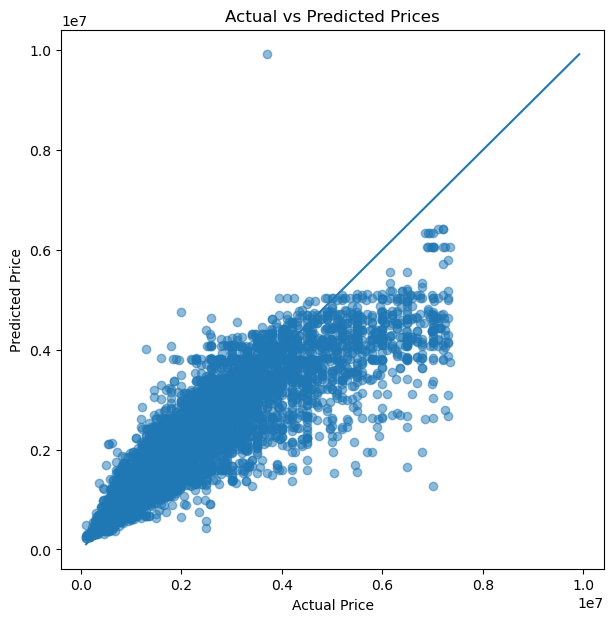

In [106]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7,7))

plt.scatter(y_test_actual, y_pred, alpha=0.5)

# خط المثالية
min_val = min(y_test_actual.min(), y_pred.min())
max_val = max(y_test_actual.max(), y_pred.max())

plt.plot([min_val, max_val], [min_val, max_val])

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")

plt.show()

🔎 Key Insights – Real Estate Price Prediction Model
1️⃣ Strong Model Performance

The Random Forest model achieved:

R² Score: 0.78 (Test Set)

Cross-Validation R²: 0.84

Mean Absolute Error (MAE): ~440K

This indicates that the model explains approximately 78% of the variance in property prices, demonstrating strong predictive capability and good generalization performance.

2️⃣ Location is the Primary Price Driver

Features such as area_name and city had the highest importance in the model.

This confirms that location is the most significant factor influencing property prices, often outweighing physical property characteristics.

3️⃣ Property Size and Layout Matter

The number of bedrooms and bathrooms showed a strong positive impact on pricing.

However, the effect varies across different areas, suggesting that property size interacts with location and market segment.

4️⃣ Property Condition Impacts Valuation

Features such as:

Completion status

Furnishing status

have a measurable influence on property prices.

Ready and furnished properties tend to command higher prices, particularly in high-demand locations.

5️⃣ Handling Outliers Significantly Improved Model Performance

Before outlier removal and transformation:

R² ≈ 0.16

After preprocessing:

R² ≈ 0.78

This highlights the importance of proper data cleaning and preprocessing in real estate datasets, which often contain extreme luxury listings.

6️⃣ Log Transformation Was Critical

Applying a logarithmic transformation to the target variable:

Reduced skewness

Improved model stability

Enhanced predictive accuracy

This confirms that real estate prices follow a right-skewed distribution rather than a normal distribution.

7️⃣ Business Value of the Model

This model can be used for:

Fair property pricing

Identifying undervalued properties

Supporting investment decisions

Assisting sales teams in pricing strategies

Market trend analysis

📌 Final Conclusion

The model demonstrates that real estate pricing is primarily driven by location, property size, and completion status. With strong cross-validation performance (R² = 0.84), the model shows high reliability and practical applicability in real-world market analysis.